<a href="https://colab.research.google.com/github/SGRGit/gwOsc/blob/master/CreateSampleSignalProc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import scipy

In [0]:
import matplotlib.pyplot as plt

In [0]:
import numpy as np
t = np.linspace(0, 1, 50)
a = np.float(np.power(1.0, -18))
f = np.float(50.0)

x = a*np.sin(2*np.pi*f*t) + a*np.cos(2*np.pi*f*t)
n = np.random.randn(len(t))
xn = x + np.random.randn(len(t))

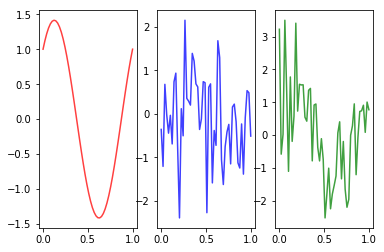

In [75]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.plot(t, x, 'r' , alpha=0.75)

ax2.plot(t, n, 'b', alpha=0.75)

ax3.plot(t, xn, 'g', alpha=0.75)

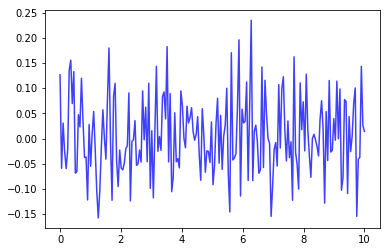